## Importing libaries

In [1]:
import pandas as pd
import seaborn as sns
import simpy 
import numpy as np
import scipy as spy
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime, timedelta
import random

## Simulating Patients Coming In and Out of Different Ememrgency Departments 

In [2]:
## ----DEF OF CONSTANTS----

LENGTH_OF_STAY = {
    'Major':9,
    'Minor':4,
    'Resus':6,
}

ARRIVALS_BEFORE_9 = {
    'Major':6,
    'Minor':4,
    'Resus':1,
}

ARRIVALS_AFTER_9 = {
    'Major':16,
    'Minor':12,
    'Resus':2,
}

SIMULATION_DURATION = 30 * 24  # Total simulation time in hours
MIN_PATIENCE_MINOR = 4
MAX_PATIENCE_MINOR = 8
start_datetime = datetime(2023,2,1,0,0)
np.random.seed(42)

In [3]:

## used for ploting dates within the plot_result function hence the name 'x'
x = []
for i in range(SIMULATION_DURATION):
    current_time = start_datetime+ timedelta(hours=i)
    x.append(current_time.strftime("%d-%H"))


# Data structures for tracking patient counts, occupancy, and queue lengths
patient_count = {
    'Major': np.zeros(SIMULATION_DURATION),
    'Minor': np.zeros(SIMULATION_DURATION),
    'Resus': np.zeros(SIMULATION_DURATION)
}

bed_usage = {
    'Major': np.zeros(SIMULATION_DURATION),
    'Minor': np.zeros(SIMULATION_DURATION),
    'Resus': np.zeros(SIMULATION_DURATION)
}

queue_lengths = {
    'Major': np.zeros(SIMULATION_DURATION),
    'Minor': np.zeros(SIMULATION_DURATION),
    'Resus': np.zeros(SIMULATION_DURATION)
}

total_occupancy = {
    'Major': np.zeros(SIMULATION_DURATION),
    'Minor': np.zeros(SIMULATION_DURATION),
    'Resus': np.zeros(SIMULATION_DURATION)
}
## ---used temp storage to hold data about patient arrival, stay and wait time with patient_id' 
patient_data = []
patient_id = 0


In [4]:
## -- Checks when the patient arrives either before 9 or after for all acuities, tracking their length of stay --

def patient_arrival(env, major_resource, minor_resource, resus_resource, ARRIVALS_BEFORE_9, ARRIVALS_AFTER_9, LENGTH_OF_STAY, patient_count):
    global patient_id
    while True:
        current_hour = env.now % 24
        if current_hour <= 9:
            n_major = np.random.poisson(lam=ARRIVALS_BEFORE_9['Major'],size=1)
            n_minor = np.random.poisson(lam=ARRIVALS_BEFORE_9['Minor'],size=1)
            n_resus = np.random.poisson(lam=ARRIVALS_BEFORE_9['Resus'],size=1)
        else:
            n_major = np.random.poisson(lam=ARRIVALS_AFTER_9['Major'],size=1)
            n_minor = np.random.poisson(lam=ARRIVALS_AFTER_9['Minor'],size=1)
            n_resus = np.random.poisson(lam=ARRIVALS_AFTER_9['Resus'],size=1)

        for _ in np.arange(0, n_major):
            stay_duration = np.random.poisson(lam=LENGTH_OF_STAY['Major'],size=1)
            patient_id += 1
            env.process(handle_patient(env, patient_id,'Major', stay_duration, patient_count, major_resource))

        for _ in np.arange(0, n_minor):
            stay_duration = np.random.poisson(lam=LENGTH_OF_STAY['Minor'],size=1)
            patient_id += 1
            env.process(handle_patient(env,patient_id, 'Minor', stay_duration, patient_count, minor_resource))

        for _ in np.arange(0, n_resus):
            stay_duration = np.random.poisson(lam=LENGTH_OF_STAY['Resus'],size=1)
            patient_id += 1
            env.process(handle_patient(env, patient_id,'Resus', stay_duration, patient_count, resus_resource))

        yield env.timeout(1)

In [5]:
## -- Tracks the patients start time since the moment they arrive, get a bed and when they leave to get most accurate results using simulation time 
## and resources and if patients such as Minor patients do not get beds they will be reneged i.e., sent home ------

def handle_patient(env, patient_id, acuity, stay_duration, patient_count, resource):
    global patient_data, wait_time
    start_time = int(env.now)
    patient_count[acuity][start_time] += 1
    total_occupancy[acuity][start_time] += 1 
    
    if acuity == 'Minor':
        reneging_time = random.uniform(MIN_PATIENCE_MINOR, MAX_PATIENCE_MINOR)
        with resource.request() as req:
            result = yield req | env.timeout(reneging_time)
            if req in result:
                bed_assinged_time = int(env.now)
                wait_time = bed_assinged_time - start_time
                patient_data.append({'Id':patient_id,
                                     'Acuity':acuity,
                                     'Start_Time':start_time,
                                     'Wait_Time':wait_time
                                    })
                yield env.timeout(stay_duration)
                end_time = int(env.now)
                patient_count[acuity][end_time] -= 1
            else:
                renege_time = int(env.now)
                patient_data.append({'Id':patient_id,
                                     'Acuity':acuity,
                                     'Start_Time':start_time,
                                     'Wait_Time':wait_time
                                    })
                patient_count[acuity][renege_time] -= 1
                print(f'patient has reneged {patient_id} at time:{renege_time}')  
    else:
        with resource.request() as req:
            yield req
            bed_assinged_time = int(env.now)
            wait_time = bed_assinged_time - start_time
            patient_data.append({'Id':patient_id,
                                 'Acuity':acuity,
                                 'Start_Time':start_time,
                                 'Wait_Time':wait_time
                                })
            yield env.timeout(stay_duration)
            end_time = int(env.now)
            patient_count[acuity][end_time] -= 1

In [6]:
## collects information about each department and how the long the queues are within each departmenet
def collect_data(env, major_resource, minor_resource, resus_resource):
    global bed_usage, queue_lengths
    while True:
        bed_usage['Major'][int(env.now)] = major_resource.count
        bed_usage['Minor'][int(env.now)] = minor_resource.count
        bed_usage['Resus'][int(env.now)] = resus_resource.count
        
        queue_lengths['Major'][int(env.now)] = len(major_resource.queue)
        queue_lengths['Minor'][int(env.now)] = len(minor_resource.queue)
        queue_lengths['Resus'][int(env.now)] = len(resus_resource.queue)

        yield env.timeout(1)

In [7]:
## --------------------------------------------MAIN FUNCTION FOR STARTING THE SIMULATION --------------------------------------------
def start_simulation(major_beds, minor_beds, resus_beds):
    global bed_usage, queue_lengths
    random.seed(42)
    env = simpy.Environment()
    # Create separate resources for each acuity
    major_resource = simpy.Resource(env, capacity=major_beds)
    minor_resource = simpy.Resource(env, capacity=minor_beds)
    resus_resource = simpy.Resource(env, capacity=resus_beds)

    env.process(patient_arrival(env, major_resource, minor_resource, resus_resource, ARRIVALS_BEFORE_9, ARRIVALS_AFTER_9, LENGTH_OF_STAY, patient_count))
    env.process(collect_data(env, major_resource, minor_resource, resus_resource))
    env.run(until=SIMULATION_DURATION)

    return patient_count

In [8]:
##---------------------------- CALCULATING THE AVERAGE WAIT TIME AND CONVERTING RESULTS INTO PLOTS----------------------------
def calculate_average_wait_time(patient_data):
    
    df_patient = pd.DataFrame(patient_data)
    df_patient['Hour'] = df_patient['Start_Time']
    average_wait_time = df_patient.groupby(['Hour','Acuity'])['Wait_Time'].mean().unstack().fillna(0)
    return average_wait_time

def calculate_wait_time_perecentiles(average_wait_time):
    acuities = ['Major','Minor', 'Resus']
    percent_under_threshold = {}
    for acuity in acuities:
        percent=average_wait_time[acuity].quantile(0.76)
        print(f'{acuity} has value at 76% = {percent}')
        percent_under_threshold[acuity]=percent
    return percent_under_threshold
        
    

In [9]:
##---------------------- PLOT FUNCTIONS FOR PLOTTING RESULTS INTO GRAPHS ---------------------- 
def plot_results(patient_count, bed_usage, queue_lengths, total_beds, total_occupancy, x):
    
    ##ADJUSTING THE GRAPH SIZE 
    plt.figure(figsize=(12, 10))
    
    # Plot occupancy over time for each acuity
    plt.subplot(3, 1, 1)
    plt.plot(x, bed_usage['Major'], label='Major Beds Occupied', color='red')
    plt.plot(x, bed_usage['Minor'], label='Minor Beds Occupied', color='green')
    plt.plot(x, bed_usage['Resus'], label='Resus Beds Occupied', color='blue')
    plt.xlabel("Time (Date)")
    plt.ylabel("Beds Occupied")
    plt.title(f"Beds Occupied over Time (Total Beds = {total_beds})")
    plt.legend()
    plt.xticks(np.arange(0,len(x), step=24), x[::24],rotation=45)

    #Plot queue length over time for each acuity
    plt.subplot(3, 1, 2)
    plt.plot(x, queue_lengths['Major'], label='Major Queue Length', color='red')
    plt.plot(x, queue_lengths['Minor'], label='Minor Queue Length', color='green')
    plt.plot(x, queue_lengths['Resus'], label='Resus Queue Length', color='blue')
    plt.xlabel("Time (date)")
    plt.ylabel("Queue Length")
    plt.title("Queue Length over Time")
    plt.legend()
    plt.xticks(np.arange(0,len(x), step=24), x[::24],rotation=45)

    ## CALCULATING THE TOTAL SUM OF EACH FOR EACH ACUITIY
    Major_cumsum = (total_occupancy['Major'])
    Minor_cumsum = (total_occupancy['Minor'])
    Resus_cumsum = (total_occupancy['Resus'])
    ## PLOTTING THE TOTAL RESULT FOR EACH ACUITY 
    plt.subplot(3, 1, 3)
    plt.plot(x, Major_cumsum, label='Major Bed Usage', color='red')
    plt.plot(x, Minor_cumsum, label='Minor Bed Usage', color='green')
    plt.plot(x, Resus_cumsum, label='Resus Bed Usage', color='blue')
    plt.xlabel("Time (date)")
    plt.ylabel("Beds requested")
    plt.title("Bed Usage over Time")
    plt.legend()
    plt.xticks(np.arange(0,len(x), step=24), x[::24],rotation=45)
    plt.tight_layout()
    plt.show()
## PLOTTING AVERAGE WAIT TIME 
def plot_average_wait_time(average_wait_time, x):
    plt.figure(figsize=(10,6))
    for acuity in average_wait_time.columns:
        plt.plot(x[:len(average_wait_time)], average_wait_time[acuity], label = f'{acuity} Average Wait time')
    plt.xlabel('simulation hours')
    plt.ylabel('Average wait time')
    plt.grid(True)
    plt.legend()
    plt.xticks(np.arange(0,len(x), step=24), x[::24],rotation=45)

In [10]:
## MEMORY CLEANING
def garbage_collector():
    global patient_count, bed_usage, queue_lengths ,total_occupancy,average_wait_time, patient_data

    for key in patient_count:
        patient_count[key] = np.zeros(SIMULATION_DURATION)
    
    for key in bed_usage:
            bed_usage[key] = np.zeros(SIMULATION_DURATION)

    for key in queue_lengths:
            queue_lengths[key] = np.zeros(SIMULATION_DURATION)
    
    for key in total_occupancy:
            total_occupancy[key] = np.zeros(SIMULATION_DURATION)
    
    patient_data = [] ##empty list
    average_wait_time = pd.DataFrame()

## Calling of All Needed Functions

/var/folders/w0/74yz1s110gbdx11l295_j6380000gp/T/ipykernel_83221/951102017.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for _ in np.arange(0, n_major):
/var/folders/w0/74yz1s110gbdx11l295_j6380000gp/T/ipykernel_83221/951102017.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for _ in np.arange(0, n_minor):
/var/folders/w0/74yz1s110gbdx11l295_j6380000gp/T/ipykernel_83221/951102017.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for _ in np.arange(0,

patient has reneged 411 at time:23
patient has reneged 495 at time:26
patient has reneged 1074 at time:51
patient has reneged 1073 at time:51
patient has reneged 2021 at time:95
patient has reneged 2053 at time:96
patient has reneged 2123 at time:98
patient has reneged 2125 at time:99
patient has reneged 2147 at time:99
patient has reneged 2150 at time:99
patient has reneged 2634 at time:121
patient has reneged 2633 at time:121
patient has reneged 2662 at time:122
patient has reneged 2667 at time:122
patient has reneged 2665 at time:122
patient has reneged 2664 at time:122
patient has reneged 2695 at time:123
patient has reneged 2698 at time:123
patient has reneged 2697 at time:123
patient has reneged 2715 at time:124
patient has reneged 2714 at time:124
patient has reneged 2712 at time:124
patient has reneged 3122 at time:143
patient has reneged 3128 at time:143
patient has reneged 3130 at time:143
patient has reneged 3157 at time:144
patient has reneged 3190 at time:145
patient has r

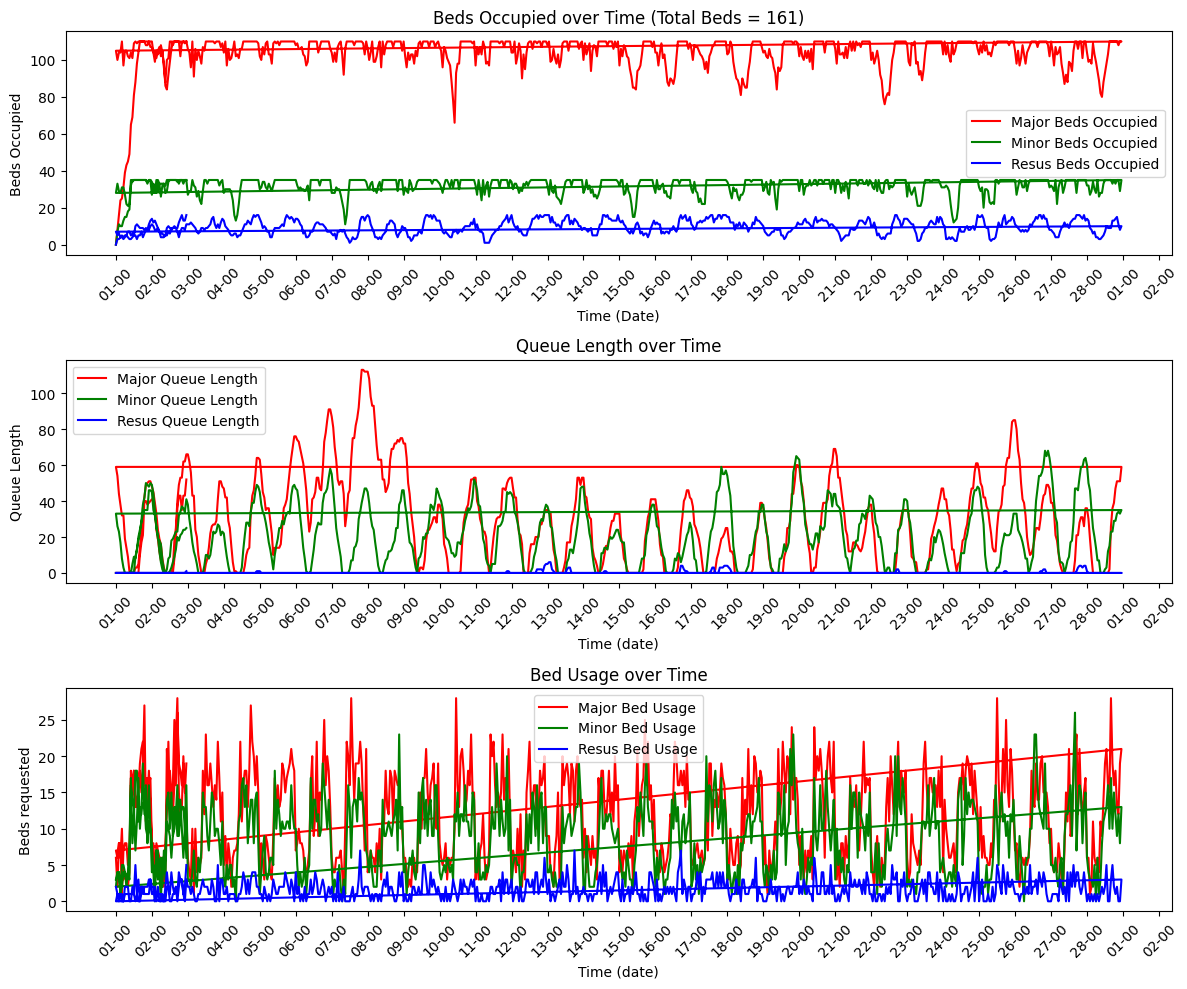

Major has value at 76% = 3.2894117647058825
Minor has value at 76% = 3.204631578947369
Resus has value at 76% = 0.0


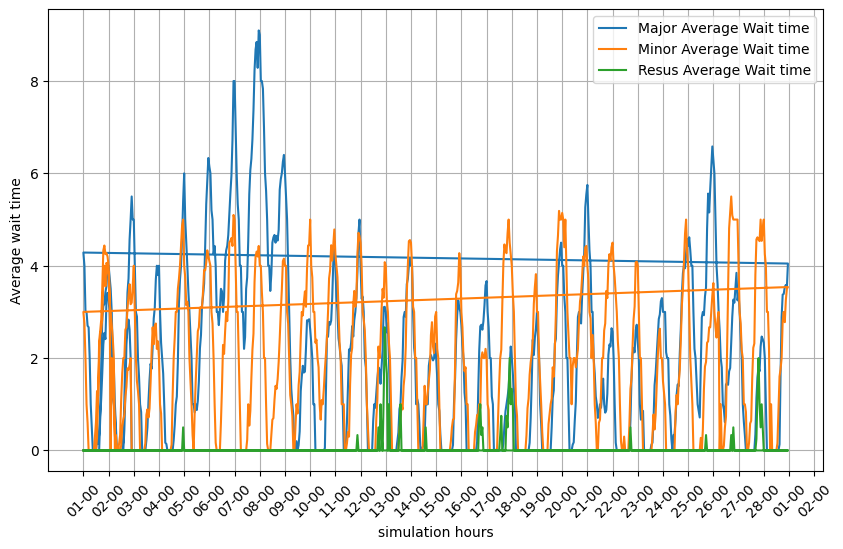

In [11]:
##ADJUSTING THE PARAMETERS AND CALLING ALL FUNCTIONS 
garbage_collector()

major_beds = 110
minor_beds = 35
resus_beds = 16
total_beds = major_beds + minor_beds + resus_beds
patient_count = start_simulation(major_beds, minor_beds, resus_beds)
df_patient_data = pd.DataFrame(patient_data)

average_wait_time = calculate_average_wait_time(patient_data)

plot_results(patient_count, bed_usage, queue_lengths, total_beds, total_occupancy,x)
plot_average_wait_time(average_wait_time,x)

percent_under_threshold = calculate_wait_time_perecentiles(average_wait_time)

In [12]:
print(f'Calculating the staff need per bed (Major)')
major_staff = major_beds * 0.3
print(int(major_staff))

Calculating the staff need per bed (Major)
33


In [13]:
print(f'Calculating the staff need per bed (Minor)')
minor_staff = minor_beds * 0.3
print(int(minor_staff))

Calculating the staff need per bed (Minor)
10


In [14]:
print(f'Calculating the staff need per bed (Resus)')
resus_staff = resus_beds * 0.3
print(int(resus_staff))

Calculating the staff need per bed (Resus)
4


In [27]:
np.diff(pd.DataFrame(patient_data).Id.unique()).argmax()

np.int64(3553)